<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparing-data" data-toc-modified-id="Preparing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparing data</a></span></li><li><span><a href="#train-test-split" data-toc-modified-id="train-test-split-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>train test split</a></span></li><li><span><a href="#feature-engineering" data-toc-modified-id="feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>feature engineering</a></span></li><li><span><a href="#modeling" data-toc-modified-id="modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>modeling</a></span><ul class="toc-item"><li><span><a href="#prediction-without-seen-item-count-feature" data-toc-modified-id="prediction-without-seen-item-count-feature-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>prediction without seen item count feature</a></span></li><li><span><a href="#single-model-based-prediction" data-toc-modified-id="single-model-based-prediction-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>single model based prediction</a></span></li></ul></li><li><span><a href="#Final-Solution---GroupKFold-CV" data-toc-modified-id="Final-Solution---GroupKFold-CV-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final Solution - GroupKFold CV</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import numpy as np

import os
import gc
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import lightgbm as lgb
from scipy.stats import hmean

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
target = 'redemption_status'
id_cols = ['id', 'campaign_id']

In [3]:
train = pd.read_csv("train.csv", index_col=None)
# test = pd.read_csv("test.csv", index_col=None)
# submission = pd.read_csv("sample_submission.csv", index_col=None)

train.shape
# , test.shape, submission.shape

(78369, 5)

# Preparing data

In [4]:
campaign_data = pd.read_csv("campaign_data.csv", index_col=None)
coupon_item_mapping = pd.read_csv("coupon_item_mapping.csv", index_col=None)
item_data = pd.read_csv("item_data.csv", index_col=None)
customer_transaction_data = pd.read_csv("customer_transaction_data.csv", index_col=None)
customer_data = pd.read_csv("customer_demographics.csv", index_col=None)

In [5]:
campaign_data['end_date'] = pd.to_datetime(campaign_data['end_date'], format='%d/%m/%y')
campaign_data['start_date'] = pd.to_datetime(campaign_data['start_date'], format='%d/%m/%y')
campaign_data['_campaign_duration'] = (campaign_data['end_date'] - campaign_data['start_date']).dt.days

In [6]:
customer_transaction_data = pd.merge(customer_transaction_data, item_data, on='item_id', how='left')

customer_transaction_data['coupon_discount'] = customer_transaction_data['coupon_discount']*-1
customer_transaction_data['other_discount'] = customer_transaction_data['other_discount']*-1

customer_transaction_data['coupon_discount_pct'] = (customer_transaction_data['coupon_discount'] /
                                                    (customer_transaction_data['selling_price'] +
                                                     customer_transaction_data['coupon_discount']))

customer_transaction_data['other_discount_pct'] = (customer_transaction_data['other_discount'] /
                                                   (customer_transaction_data['selling_price'] +
                                                    customer_transaction_data['other_discount']))

customer_transaction_data['date'] = pd.to_datetime(customer_transaction_data['date'])

In [7]:
train = pd.merge(train, customer_data, on='customer_id', how='left')
# test = pd.merge(test, customer_data, on='customer_id', how='left')

train = pd.merge(train, campaign_data, on='campaign_id', how='left')
# test = pd.merge(test, campaign_data, on='campaign_id', how='left')

In [8]:
def split_vals(x, campaigns):
    return (x[~x.campaign_id.isin(campaigns)].reset_index(drop=True), 
            x[x.campaign_id.isin(campaigns)].reset_index(drop=True))

test_campaigns = [11, 12, 13]
train, test = split_vals(train, test_campaigns)

In [9]:
min_campaign_startdate = test.start_date.min()
customer_transaction_data = customer_transaction_data[customer_transaction_data.date<min_campaign_startdate]
customer_transaction_data = customer_transaction_data.reset_index(drop=True)

customer_transaction_data.shape

(1130331, 12)

In [10]:
coupon_item_mapping = pd.merge(coupon_item_mapping, item_data, on='item_id', how='left')

for col in tqdm(['item_id', 'brand', 'brand_type', 'category']):
    agg_df = coupon_item_mapping.groupby('coupon_id')[col].nunique().to_frame('_unique_'+col+'_per_coupon')
    agg_df = agg_df.reset_index()

    train = pd.merge(train, agg_df, on='coupon_id', how='left')
    test = pd.merge(test, agg_df, on='coupon_id', how='left')

In [11]:
coupon_item_set = coupon_item_mapping.groupby('coupon_id').item_id.apply(set).to_frame("coupon_items")

In [12]:
train = pd.merge(train, coupon_item_set, on='coupon_id', how='left')
test = pd.merge(test, coupon_item_set, on='coupon_id', how='left')

In [13]:
customer_transaction_data = customer_transaction_data.drop_duplicates()
desired_customers = train['customer_id']+test['customer_id']
customer_transaction_data = customer_transaction_data[customer_transaction_data.customer_id.isin(desired_customers)]
customer_transaction_data = customer_transaction_data.reset_index(drop=True)

# train test split

In [14]:
from sklearn.metrics import roc_auc_score
def process_data(df):
    for col in ['age_range', 'marital_status', 'family_size', 
                'no_of_children', 'campaign_type']:
        df[col] = df[col].astype('category')
#         df[col] = df[col].cat.codes
        
    return df

def scoring_func(x, y): return roc_auc_score

In [15]:
train = process_data(train)
test = process_data(test)

In [16]:
train = train.sort_values(by='start_date').reset_index(drop=True)

In [17]:
valid_campaigns = [8, 9, 10]
train_df, valid_df = split_vals(train, valid_campaigns)
train_df.shape, valid_df.shape

((22985, 20), (27446, 20))

In [18]:
min_campaign_startdate = valid_df.start_date.min()
customer_transaction_data_v = customer_transaction_data[customer_transaction_data.date<min_campaign_startdate]
customer_transaction_data_v = customer_transaction_data_v.reset_index(drop=True)

customer_transaction_data_v.shape

(891327, 12)

# feature engineering

In [19]:
def generate_agg_features(overall):
    agg_df = overall.groupby('coupon_id').agg({"campaign_id": ["nunique"],
                                               "customer_id": ["nunique"], 
                                               "id":["count"]})
    agg_df.columns = ["coupon_" + a +"_" + b for a,b in agg_df.columns]
    agg_df = agg_df.reset_index()

    overall = pd.merge(overall, agg_df, on='coupon_id', how='left')

    agg_df = overall.groupby('campaign_id').agg({"coupon_id": ["nunique"],
                                                 "customer_id": ["nunique"], 
                                                 "id":["count"]})
    agg_df.columns = ["campaign_" + a +"_" + b for a,b in agg_df.columns]
    agg_df = agg_df.reset_index()
    overall = pd.merge(overall, agg_df, on='campaign_id', how='left')

    agg_df = overall.groupby('customer_id').agg({"campaign_id": ["nunique"],
                                                 "coupon_id": ["nunique"],
                                                 "id":["count"]
                                                })
    agg_df.columns = ["customer_" + a +"_" + b for a,b in agg_df.columns]
    agg_df = agg_df.reset_index()
    overall = pd.merge(overall, agg_df, on='customer_id', how='left')
    
    return overall

In [20]:
def gen_customer_feature(customer_transaction_data, campaign_start_dates):
    customer_seen_items = pd.DataFrame()
    for col in tqdm(campaign_start_dates):
        temp = customer_transaction_data.groupby('customer_id').agg({"item_id":[set, "nunique"],
                                                                     "quantity":"sum",
                                                                     "coupon_discount_pct":"mean",
                                                                     "other_discount_pct":"mean",
                                                                    })
        temp.columns = ['seen_items', 'item_number', 'quantity', 
                        'coupon_discount_pct_mean', 'other_discount_pct_mean']
        temp['qty_per_item'] = temp['quantity'] / temp['item_number']
        temp['_start_date'] = col
        temp = temp.reset_index()

        customer_seen_items = pd.concat((customer_seen_items, temp), axis=0)

    return customer_seen_items

In [21]:
def merging_customer_feature(customer_seen_items, data):
    customer_seen_items = customer_seen_items.sort_values(by='_start_date').reset_index(drop=True)
    data = data.sort_values(by='start_date').reset_index(drop=True)

    data = pd.merge_asof(data,
                            customer_seen_items,
                            left_on='start_date',
                            right_on='_start_date',
                            direction='backward',
                            by='customer_id')
    
#     data['seen_items_count'] = 0
    seen_items_index = data['seen_items'].notnull()
    data.loc[seen_items_index, 
             'seen_items_count'] = data.loc[seen_items_index].progress_apply(lambda x: 
                                                                             len(x['coupon_items'] & x['seen_items']), 
                                                                             axis=1)
    
    return data

In [22]:
train['is_train'] = 1
test['is_train'] = 0

overall = pd.concat((train, test), ignore_index=True, sort=False)
overall = generate_agg_features(overall)

train = overall[overall['is_train']==1].reset_index(drop=True)
test = overall[overall['is_train']==0].reset_index(drop=True)

In [23]:
campaign_start_dates = np.unique(np.append(train.start_date.unique(), 
                                           test.start_date.unique()))

campaign_start_dates = train.start_date.unique()
customer_features = gen_customer_feature(customer_transaction_data, campaign_start_dates)

train = merging_customer_feature(customer_features, train)
test = merging_customer_feature(customer_features, test)

In [25]:
train_df['is_train'] = 1
valid_df['is_train'] = 0

overall = pd.concat((train_df, valid_df), ignore_index=True, sort=False)
overall = generate_agg_features(overall)

train_df = overall[overall['is_train']==1].reset_index(drop=True)
valid_df = overall[overall['is_train']==0].reset_index(drop=True)

In [26]:
campaign_start_dates = np.unique(np.append(train_df.start_date.unique(), 
                                           valid_df.start_date.unique()))

customer_features = gen_customer_feature(customer_transaction_data_v, campaign_start_dates)
train_df = merging_customer_feature(customer_features, train_df)
valid_df = merging_customer_feature(customer_features, valid_df)

In [27]:
del overall
gc.collect()

28

In [28]:
def generate_coupon_features(customer_transaction_data, train, test):
    temp = customer_transaction_data.groupby('item_id').agg({"customer_id":"nunique",
                                                             "other_discount":"sum",
                                                             "coupon_discount":"sum"
                                                            })
    temp['coupon_discount_per_customer'] = temp['coupon_discount'] / temp['customer_id']
    temp = temp.reset_index()
    temp = temp.rename(columns={'customer_id':'item_customers', 'quantity':'item_qty'})

    coupon_item_agg = pd.merge(coupon_item_mapping, temp, on='item_id', how='left')
    temp = coupon_item_agg.groupby('coupon_id').agg({"coupon_discount_per_customer":["mean", "std"],
                                                     "item_customers":["mean","std"],
                                                        })
    col_names = [a + "_" + b for a,b in temp.columns]
    temp.columns = col_names
    temp = temp.reset_index()

    original_col = list(temp.columns)
    renamed_col = [col if col!='coupon_id' else col for col in temp.columns]
    temp = temp.rename(columns=dict(zip(original_col, renamed_col)))

    train = pd.merge(train, temp, on='coupon_id', how='left')
    test = pd.merge(test, temp, on='coupon_id', how='left')
    
    return train, test

In [29]:
train, test = generate_coupon_features(customer_transaction_data, train, test)
train_df, valid_df = generate_coupon_features(customer_transaction_data_v, train_df, valid_df)

# modeling

In [30]:
for data in [train, test, train_df, valid_df]:
    print(data.start_date.min(), data.start_date.max(),
         data.end_date.min(), data.end_date.max())

2012-08-12 00:00:00 2013-04-08 00:00:00 2012-09-21 00:00:00 2013-05-10 00:00:00
2013-04-22 00:00:00 2013-05-19 00:00:00 2013-05-24 00:00:00 2013-07-05 00:00:00
2012-08-12 00:00:00 2013-02-02 00:00:00 2012-09-21 00:00:00 2013-03-08 00:00:00
2013-02-16 00:00:00 2013-04-08 00:00:00 2013-04-05 00:00:00 2013-05-10 00:00:00


## prediction without seen item count feature

In [70]:
predictors = [
    'coupon_id',
    'campaign_type',
    '_campaign_duration',
    'income_bracket',
    '_unique_item_id_per_coupon',
    '_unique_brand_per_coupon',
    '_unique_category_per_coupon',
    'coupon_discount_pct_mean',
    'other_discount_pct_mean',
    'qty_per_item',
    'coupon_discount_per_customer_mean',
    'item_customers_mean',
    'coupon_id_count',
    'campaign_id_count',
    'customer_id_count',
    'item_number']

In [71]:
m = lgb.LGBMClassifier(n_estimators=10000, 
#                                   max_depth=4, 
                                  learning_rate=0.0011, 
                                  colsample_bytree=0.5)

m.fit(train_df[predictors],
      train_df[target],
      eval_set=[(valid_df[predictors],
                 valid_df[target])],
      eval_metric='auc', 
      early_stopping_rounds=500,
      verbose=100)

train_score = m.predict_proba(train_df[predictors])[:,1]
valid_score = m.predict_proba(valid_df[predictors])[:,1]
print("train {} valid {}".format(roc_auc_score(train_df[target], train_score),
                                 roc_auc_score(valid_df[target], valid_score)))

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's auc: 0.82904	valid_0's binary_logloss: 0.0470129
[200]	valid_0's auc: 0.835004	valid_0's binary_logloss: 0.0459787
[300]	valid_0's auc: 0.83691	valid_0's binary_logloss: 0.0453186
[400]	valid_0's auc: 0.843198	valid_0's binary_logloss: 0.0447257
[500]	valid_0's auc: 0.846847	valid_0's binary_logloss: 0.0441897
[600]	valid_0's auc: 0.850011	valid_0's binary_logloss: 0.0437536
[700]	valid_0's auc: 0.851196	valid_0's binary_logloss: 0.0434039
[800]	valid_0's auc: 0.852461	valid_0's binary_logloss: 0.0430976
[900]	valid_0's auc: 0.853731	valid_0's binary_logloss: 0.0428451
[1000]	valid_0's auc: 0.854971	valid_0's binary_logloss: 0.0426656
[1100]	valid_0's auc: 0.855493	valid_0's binary_logloss: 0.0424986
[1200]	valid_0's auc: 0.856072	valid_0's binary_logloss: 0.0423714
[1300]	valid_0's auc: 0.857195	valid_0's binary_logloss: 0.0422393
[1400]	valid_0's auc: 0.857704	valid_0's binary_logloss: 0.042174
[1500]	vali

In [72]:
predictors = [
    'coupon_id',
    'campaign_type',
    '_campaign_duration',
    'income_bracket',
    '_unique_item_id_per_coupon',
    '_unique_brand_per_coupon',
    '_unique_category_per_coupon',
    'coupon_discount_pct_mean',
    'other_discount_pct_mean',
    'qty_per_item',
    'coupon_discount_per_customer_mean',
    'item_customers_mean',
    'coupon_id_count',
    'campaign_id_count',
    'customer_id_count',
    'item_number',
    'seen_items_count']

In [73]:
m = lgb.LGBMClassifier(n_estimators=10000, 
#                                   max_depth=4, 
                                  learning_rate=0.0011, 
                                  colsample_bytree=0.5)

m.fit(train_df[predictors],
      train_df[target],
      eval_set=[(valid_df[predictors],
                 valid_df[target])],
      eval_metric='auc', 
      early_stopping_rounds=500,
      verbose=100)

train_score = m.predict_proba(train_df[predictors])[:,1]
valid_score = m.predict_proba(valid_df[predictors])[:,1]
print("train {} valid {}".format(roc_auc_score(train_df[target], train_score),
                                 roc_auc_score(valid_df[target], valid_score)))

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's auc: 0.921703	valid_0's binary_logloss: 0.0440528
[200]	valid_0's auc: 0.920782	valid_0's binary_logloss: 0.0421126
[300]	valid_0's auc: 0.922057	valid_0's binary_logloss: 0.0407492
[400]	valid_0's auc: 0.923031	valid_0's binary_logloss: 0.0397105
[500]	valid_0's auc: 0.924008	valid_0's binary_logloss: 0.0388715
[600]	valid_0's auc: 0.924502	valid_0's binary_logloss: 0.0382292
[700]	valid_0's auc: 0.92544	valid_0's binary_logloss: 0.0377117
[800]	valid_0's auc: 0.925846	valid_0's binary_logloss: 0.0372859
[900]	valid_0's auc: 0.926262	valid_0's binary_logloss: 0.0369541
[1000]	valid_0's auc: 0.92638	valid_0's binary_logloss: 0.0366732
[1100]	valid_0's auc: 0.92632	valid_0's binary_logloss: 0.036447
[1200]	valid_0's auc: 0.926435	valid_0's binary_logloss: 0.036264
[1300]	valid_0's auc: 0.926674	valid_0's binary_logloss: 0.0361242
[1400]	valid_0's auc: 0.927027	valid_0's binary_logloss: 0.0360216
[1500]	valid_

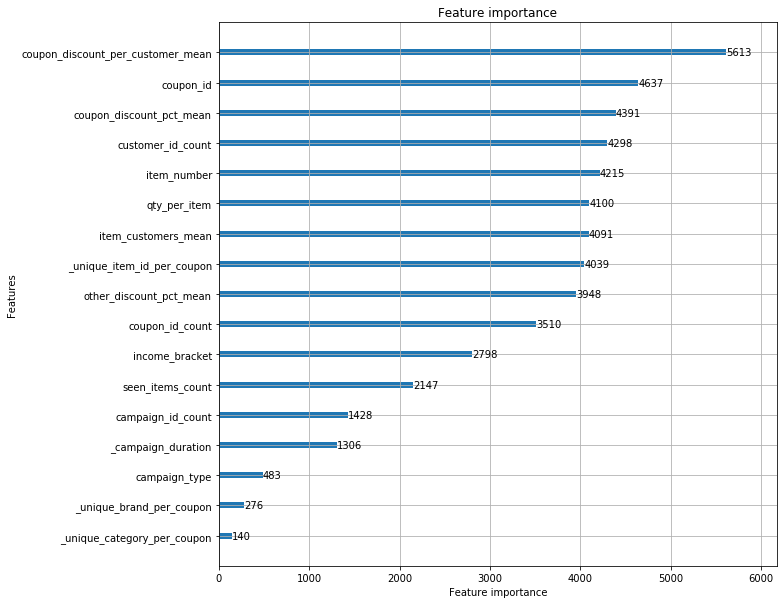

In [42]:
lgb.plot_importance(m, figsize=(10,10))

In [43]:
m.best_iteration_

1714

## single model based prediction

In [58]:
X_train = train[predictors].copy()
y_train = train[target]

X_test = test[predictors].copy()
y_test = test[target]

In [60]:
m_final = lgb.LGBMClassifier(n_estimators=1800, 
#                                   max_depth=4, 
                                  learning_rate=0.0011, 
                                  colsample_bytree=0.5)

m_final.fit(X_train, y_train)
print("test score {} ".format(roc_auc_score(y_test, 
                                            m_final.predict_proba(X_test)[:,1])))

test score 0.9319659406017933 


# Final Solution - GroupKFold CV 

In [61]:
train = train.sort_values(by='start_date').reset_index(drop=True)

In [62]:
X_train = train.copy()
y_train = train[target]

X_test = test.copy()
y_test = test[target]

In [63]:
group = X_train['campaign_id'].values

In [64]:
predictors = ['coupon_id',
 'campaign_type',
 '_campaign_duration',
 'income_bracket',
 '_unique_item_id_per_coupon',
 '_unique_brand_per_coupon',
 '_unique_category_per_coupon',
 'coupon_id_count',
 'campaign_id_count',
 'customer_id_count',
]

predictors2 = ['coupon_discount_pct_mean',
 'other_discount_pct_mean',
 'qty_per_item',
 'seen_items_count',
 'coupon_discount_per_customer_mean',
 'item_customers_mean']
    
drop_cols = ['start_date', 'customer_id', 'coupon_items', 'id']
drop_cols2 = ['seen_items', '_start_date', 'item_number', 
              'quantity', 'coupon_discount_per_customer_std', 'item_customers_std']

In [65]:
X_train = X_train[predictors+drop_cols+[target]]
X_test = X_test[predictors+predictors2]

In [66]:
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, cross_val_predict, GroupKFold
from sklearn.metrics import roc_auc_score
def scoring(y_true, y_hat):
    return roc_auc_score(y_true, y_hat)

kf = GroupKFold(n_splits=5)
    
val_scores = []
true_vals = []
prediction_vals = []
test_prediction = []
for n_fold, (train_index, test_index) in (enumerate(kf.split(X_train, y_train, groups=group))):
    X_train_temp = X_train.iloc[train_index].reset_index(drop=True)
    X_val_temp = X_train.iloc[test_index].reset_index(drop=True)
    X_test_temp = X_test.reset_index(drop=True)
    
    # determining transaction history based of minimum campaign start date
    min_campaign_startdate = X_val_temp.start_date.min()
    customer_transaction_data_v = customer_transaction_data[customer_transaction_data.date<min_campaign_startdate]
    customer_transaction_data_v = customer_transaction_data_v.reset_index(drop=True)

    # finding unique campaign start date
    campaign_start_dates = np.unique(np.append(X_train_temp.start_date.unique(), 
                                               X_val_temp.start_date.unique()))

    # customer features
    customer_features = gen_customer_feature(customer_transaction_data_v, campaign_start_dates)
    X_train_temp = merging_customer_feature(customer_features, X_train_temp)
    X_val_temp = merging_customer_feature(customer_features, X_val_temp)
    
    # coupon features
    X_train_temp, X_val_temp = generate_coupon_features(customer_transaction_data_v, 
                                                        X_train_temp, 
                                                        X_val_temp)
    
    y_train_temp = X_train_temp[target]
    X_train_temp = X_train_temp.drop(target, axis=1)
    y_val_temp = X_val_temp[target]
    X_val_temp = X_val_temp.drop(target, axis=1)

    X_train_temp.drop(drop_cols+drop_cols2, axis=1, inplace=True)
    X_val_temp.drop(drop_cols+drop_cols2, axis=1, inplace=True)

    model = lgb.LGBMClassifier(n_estimators=10000, 
#                                   max_depth=4, 
#                       seed=seed,
                      learning_rate=0.0011, 
                      colsample_bytree=0.4)

    model.fit(X_train_temp,
          y_train_temp,
          eval_set=[(X_val_temp,
                     y_val_temp)],
          eval_metric='auc', 
          early_stopping_rounds=500, 
          verbose=0)

    # valid prediction
    y_hat_valid = model.predict_proba(X_val_temp)[:, 1]
    
    # test prediction
    X_test_temp = X_test_temp.reindex(columns=X_train_temp.columns)
    y_hat_test = model.predict_proba(X_test_temp)[:, 1]

    prediction_vals.extend(y_hat_valid)
    true_vals.extend(y_val_temp)
    test_prediction.append(y_hat_test)

    # calculate score 
    score_valid = scoring(y_val_temp, y_hat_valid)
    val_scores.append(score_valid)
    print("Fold {} Score {}".format(n_fold+1, score_valid))
print("CV Score is {}".format(scoring(true_vals, prediction_vals)))


Fold 1 Score 0.9345134376480722



Fold 2 Score 0.875101405186151



Fold 3 Score 0.8793240700535534



Fold 4 Score 0.8138337591766229



Fold 5 Score 0.8888868907751083
CV Score is 0.8709230391226047


In [74]:
preds = np.mean(test_prediction, axis=0)

In [75]:
roc_auc_score(y_test, preds)

0.9320814140889211